# Introduction

This competition is hosted by the third largest insurance company in Brazil: [Porto Seguro](https://en.wikipedia.org/wiki/Porto_Seguro_S.A.) with the task of predicting the *probability that a driver will initiate an insurance claim in the next year.*

This notebook will aim to provide some interactive charts and analysis of the competition data by way of the Python visualisation library Plot.ly and hopefully bring some insights and beautiful plots that others can take and replicate. Plot.ly is one of the main products offered by the software company - [Plotly](https://plot.ly/) which specializes in providing online graphical and statistical visualisations (charts and dashboards) as well as providing an API to a whole rich suite of programming languages and tools such as Python, R, Matlab, Node.js etc.

Listed below for easy convenience are links to the various Plotly plots in this notebook:

* Simple horizontal bar plot - Used to inspect the Target variable distribution
* Correlation Heatmap plot  - Inspect the correlation between the different features
* Scatter plot - Compare the feature importances generated by Random Forest and Gradient-Boosted model
* Vertical bar plot - List in Descending order, the importance of the various features
* 3D Scatter plot 

The themes in this notebook can be briefly summarized follows:

**1. Data Quality Checks** - Visualising and evaluating all missing/Null values (values that are -1)

**2. Feature distributions** - Correlation plots and inspection of the Binary, categorical and other variables

**3. Feature importance ranking via learning models** - Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process.

In [2]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

Let us load in the training data provided using Pandas:

In [3]:
train = pd.read_csv("train.csv")
train.head()
type(train)

pandas.core.frame.DataFrame

In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality checks

**Null or missing values check**

As part of our quality checks, let us quick look at whether there are any null values in the train dataset as follows:

In [5]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

* Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as ["Values of -1 indicate that the feature was missing from the observation"](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data). Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.


Here we can see that which columns contained -1 in their values so we could easily for example make a blanket replacement of all -1 with nulls first as follows:

In [6]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

Next, we can use resident Kaggler's [Aleksey Bilogur](https://www.kaggle.com/residentmario) - creator of the  "Missingno" package which is a most useful and convenient tool in visualising missing values in the dataset, so check it out.

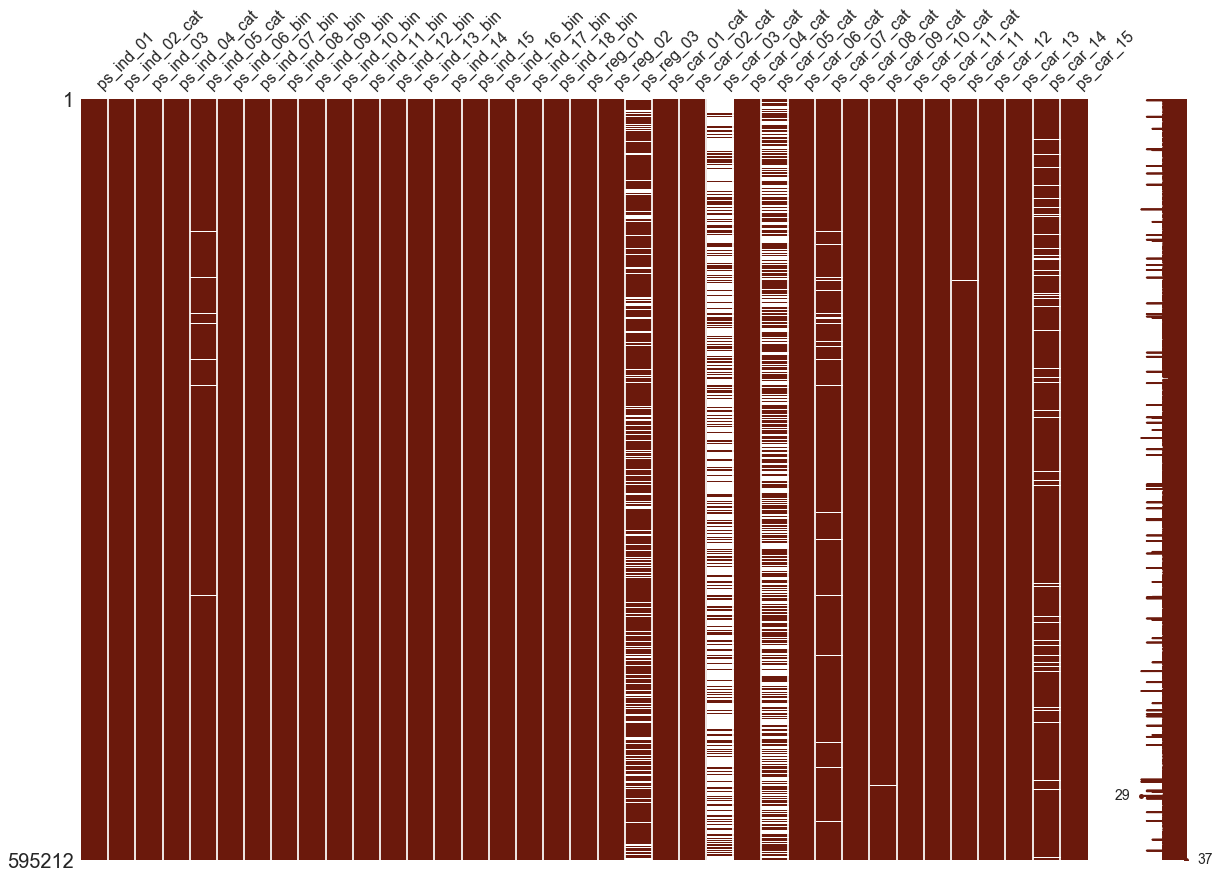

In [8]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

As we can see, the missing values now become much more apparent and clear when we visualise it, where the empty white bands (data that is missing) superposed on the vertical dark red bands (non-missing data) reflect the nullity of the data in that particular column. In this instance, we can observe that there are 7 features out of the 59 total features (although as rightly pointed out by Justin Nafe in the comments section there are really a grand total of 13 columns with missing values) that actually contained null values. This is due to the fact that the missingno matrix plot can only comfortable fit in approximately 40 odd features to one plot after which some columns may be excluded, and hence the remaining 5 null columns have been excluded. To visualize all nulls, try changing the figsize argument as well as tweaking how we slice the dataframe.

For the 7 null columns that we are able to observe, they are hence listed here as follows:

**ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14**

Most of the missing values occur in the columns suffixed with _cat. One should really take further note of the columns ps_reg_03, ps_car_03_cat and ps_car_05_cat. Evinced from the ratio of white to dark bands, it is very apparent that a big majority of values are missing from these 3 columns, and therefore a blanket replacement of -1 for the nulls might not be a very good strategy.



**Target variable inspection**

Another standard check normally conducted on the data is with regards to our target variable, where in this case, the column is conveniently titled "target". The target value also comes by the moniker of class/label/correct answer and is used in supervised learning models along with the corresponding data that is given (in our case all our train data except the id column) to learn the function that best maps the data to our target in the hope that this learned function can generalize and predict well with new, u

In [9]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

Hmmn, the target variable is rather imbalanced so it might be something to keep in mind. An imbalanced target will prove quite

**Datatype check**

This check is carried out to see what kind of datatypes the train set is comprised of : integers or characters or floats just to gain a better overview of the data we were provided with.

In [10]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

As alluded to above, there are a total of 59 columns that make up the train dataset and as we can observe from this check, the features/columns consist of only two datatypes - Integer and floats. 

Another point to note is that Porto Seguro has actually provided us data with headers that come suffixed with abbreviations such as "_bin", "_cat" and "_reg", where they have given us a rough explanation that _bin indicates binary features while _cat indicates categorical features whilst the rest are either continuous or ordinal features. Here I shall simplify this a bit further just by looking at float values (probably only the continuous features) and integer datatypes (binary, categorical and ordinal features).

In [12]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])


        ps_reg_01  ps_reg_02  ps_reg_03  ps_car_12  ps_car_13  ps_car_14  \
0             0.7        0.2   0.718070   0.400000   0.883679   0.370810   
1             0.8        0.4   0.766078   0.316228   0.618817   0.388716   
2             0.0        0.0  -1.000000   0.316228   0.641586   0.347275   
3             0.9        0.2   0.580948   0.374166   0.542949   0.294958   
4             0.7        0.6   0.840759   0.316070   0.565832   0.365103   
5             0.9        1.8   2.332649   0.445982   0.879049   0.406202   
6             0.6        0.1   0.617454   0.316228   0.639683   0.368782   
7             0.7        0.4   0.607248   0.446990   0.900574   0.374833   
8             0.9        0.7   0.901388   0.400000   0.780641   0.407431   
9             0.9        1.4   2.316652   0.447214   1.458184   0.390256   
10            0.5        0.4   0.795692   0.447214   0.875198   0.429535   
11            0.9        0.1   0.378319   0.374166   0.954491   0.379342   
12          

## Correlation plots

As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"

**Correlation of float features**

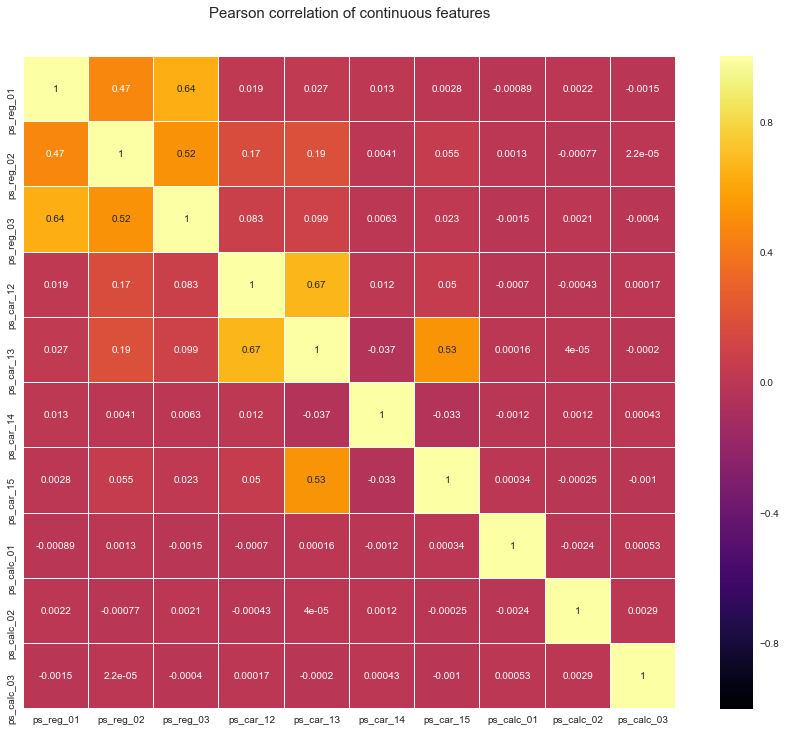

In [13]:
colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the features that display a somewhat substantial positive correlation are listed as follows:

**(ps_reg_01, ps_reg_03)**

**(ps_reg_02, ps_reg_03)**

**(ps_car_12, ps_car_13)**

**(ps_car_13, ps_car_15)**

**Correlation of integer features**

For the columns of interger datatype, I shall now switch to using the Plotly library to show how one can also generate a heatmap of correlation values interactively. Much like our earlier Plotly plot, we generate a heatmap object by simply invoking the "go.Heatmap". Here we have to provide values to three different axes, where x and y axes take in the column names while the correlation value is provided by the z-axis. The colorscale attribute takes in keywords that correspond to different color palettes that you will see in the heatmap where in this example, I have used the Greys colorscale (others include Portland and Viridis - try it for yourself). 

In [14]:
train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        text = True ,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Similarly, we can observe that there are a huge number of columns that are not linearly correlated with each other at all, evident from the fact that we observe quite a lot of 0 value cells in our correlation plot. This is quite a useful observation to us, especially if we are trying to perform dimensionality reduction transformations such as Principal Component Analysis (PCA), this would require a certain degree of correlation  . We can note some features of interest are as follows:

***Negatively correlated features*** : ps_ind_06_bin, ps_ind_07_bin,  ps_ind_08_bin,  ps_ind_09_bin

One interesting aspect to note is that in our earlier analysis on nullity, ps_car_03_cat and ps_car_05_cat were found to contain many missing or null values. Therefore it should come as no surprise that both these features show quite a strong positive linear correlation to each other on this basis, albeit one that may not really reflect the underlying truth for the data.

## Binary features inspection

Another aspect of the data that we may want to inspect would be the columns that only contain binary values, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly barplot of these binary values as follows:

In [15]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [16]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

Here we observe that there are 4 features : ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. This begs the question of whether these features are useful at all as they do not contain much information about the other class vis-a-vis the target.

## Categorical and Ordinal feature inspection

Let us first take a look at the features that are termed categorical as per their suffix "_cat". 

## Feature importance via Random Forest

Let us now implement a Random Forest model where we fit the training data with a Random Forest Classifier and look at the ranking of the features after the model has finished training. This is a quick way of using an ensemble model (ensemble of weak decision tree learners applied under Bootstrap aggregated) which does not require much parameter tuning in obtaining useful feature importances and is also pretty robust to target imbalances. We call the Random Forest as follows:


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

**Plot.ly Scatter Plot of feature importances**

Having trained the Random Forest, we can obtain the list of feature importances by invoking the attribute "feature_importances_" and plot our next Plotly plot, the Scatter plot.

Here we invoke the command Scatter and as per the previous Plotly plots, we have to define our y and x-axes. However the one thing that we pay attention to in scatter plots is the marker attribute. It is the marker attribute where we define and hence control the size, color and scale of the scatter points embedded.

In [15]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Furthermore we could also display a sorted list of all the features ranked by order of their importance, from highest to lowest via the same plotly barplots as follows:

In [16]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

**Decision Tree visualisation**

One other interesting trick or technique oft used would be to visualize the tree branches or decisions made by the model. For simplicity, I fit a decision tree (of max_depth = 3), use the export to graph visualization attribute in sklearn "export_graphviz" and then export and import the tree image for embedding into this notebook.

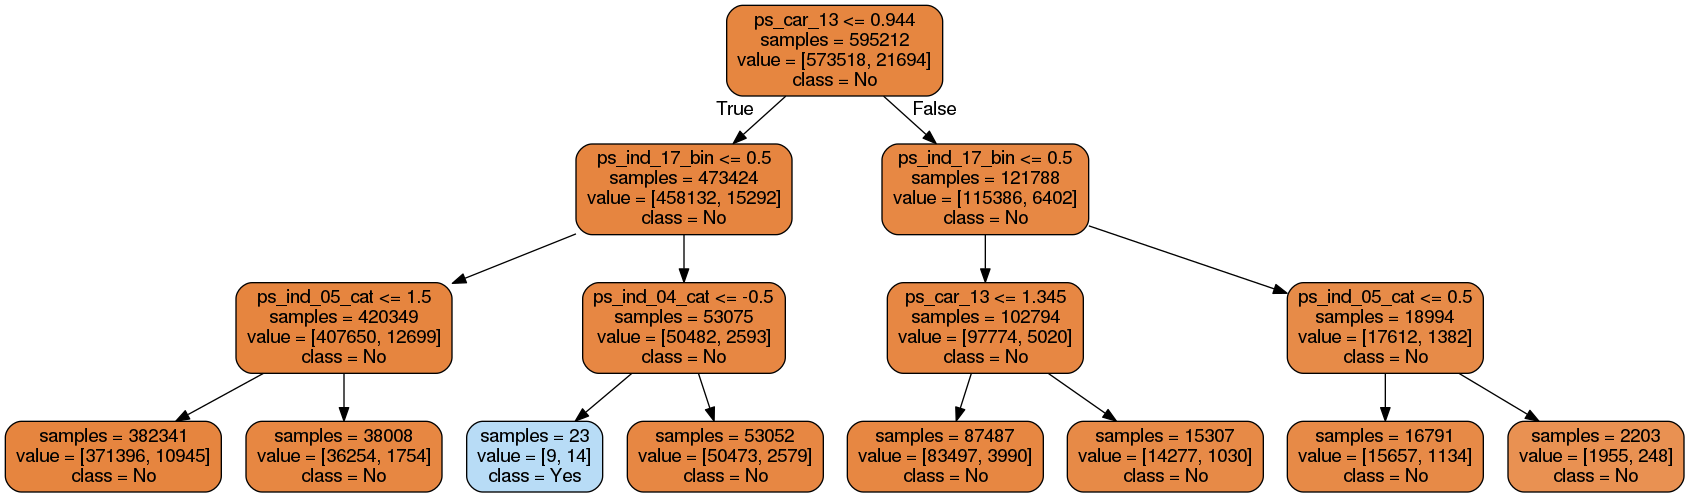

In [17]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

## Feature importance via Gradient Boosting model

Just for curiosity, let us try another learning method in getting our feature importances. This time, we use a Gradient Boosting classifier to fit to the training data . Gradient Boosting proceeds in a forward stage-wise fashion, where at each stage regression tress are fitted on the gradient of the loss function (which defaults to the deviance in Sklearn implementation). 

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [19]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [20]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

Interestingly we observe that in both Random forest and Gradient Boosted learning models, the most important feature that both models picked out was the column : **ps_car_13**. 

This particular feature warrants further investigation so let us conduct a deep-dive into it.


# Conclusion

# *To Be Continued..*